In [1]:
from TwoDimProblem import TwoDimProblem
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Speed Test compared to non-compiled version

In [24]:
p = TwoDimProblem(value_range=5)
X, y = p.createData(soln_rank=2, noise_frac=0, samples=500)
X_batch, y_batch = X[:5], y[:5].reshape(-1,1)
print(f"X_batch: {X_batch.shape}")
print(f"y_batch: {y_batch.shape}")

X_batch: (5, 2)
y_batch: (5, 1)


In [25]:
from mlp import MultiLayerPerceptron
m = MultiLayerPerceptron(
    epochs=50, 
    lr=0.1,
    activation='sigmoid',
    input_layer=2, 
    hidden_layers=[100,50],
    output_layer=1)
m.fit(X, y, batch_size=1, compiled=True)

100%|██████████| 50/50 [00:04<00:00, 11.50it/s]


In [26]:
from mlp import MultiLayerPerceptron
m = MultiLayerPerceptron(
    epochs=50, 
    lr=0.1,
    activation='sigmoid',
    input_layer=2, 
    hidden_layers=[10,10],
    output_layer=1)
m.fit(X, y, batch_size=1, compiled=False)

100%|██████████| 50/50 [00:02<00:00, 21.33it/s]


# Test MLP from other file

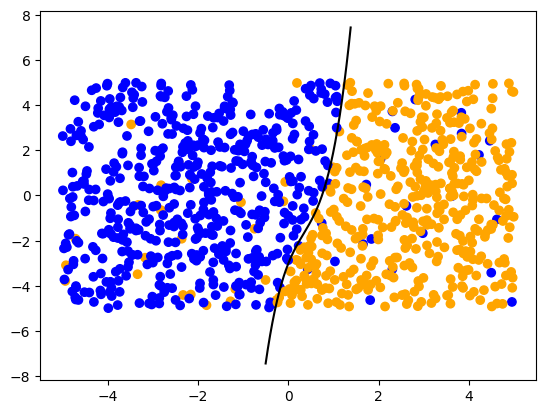

In [11]:
p = TwoDimProblem(value_range=5)
X, y = p.createData(soln_rank=3, noise_frac=0.05, samples=1000)
p.plotData(True)

100%|██████████| 100/100 [00:08<00:00, 11.56it/s]


Accuracy = 0.933


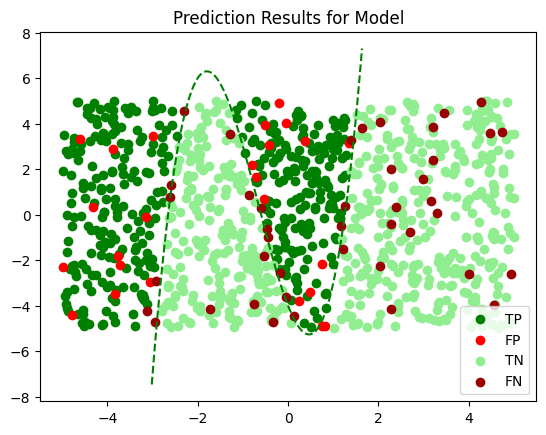

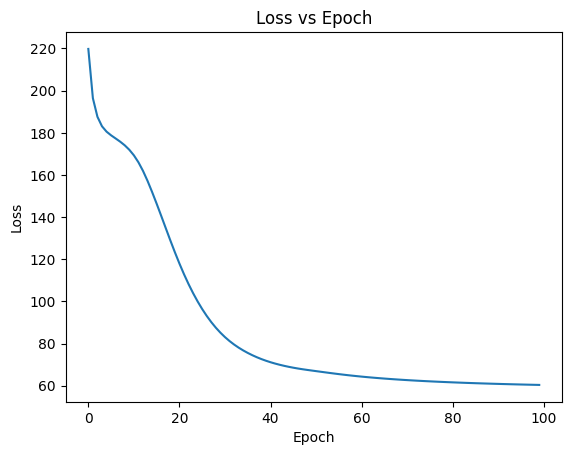

In [96]:
from mlp import MultiLayerPerceptron
m = MultiLayerPerceptron(
    epochs=100, 
    lr=0.1,
    activation='sigmoid',
    input_layer=2, 
    hidden_layers=[4,3],
    output_layer=1)
    
m.fit(X,y, batch_size=2)
pred = m.predict(X)
p.plotPred(pred, show_correct=True)
m.plot_loss()